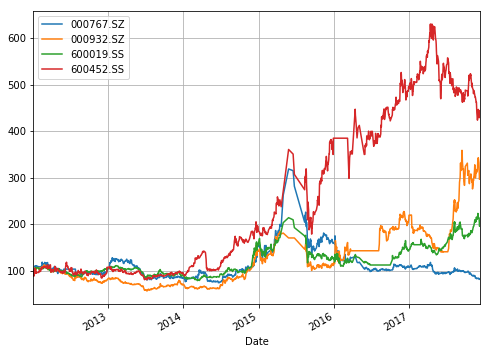

In [39]:
#1. 利用Pandas从Yahoo网上下载五家上市公司的5到10年的日收盘数据，以图形方式展示了规范化之后的时间序列数据。
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas_datareader import data as dt
%matplotlib inline
'''佛祖保佑，稳赚不赔，好股在手，天下我有，急急如律令'''
symbols = ['600452.SS', '000932.SZ','000767.SZ', '600019.SS']
#读取日收盘数据，展示规范化之后的图
data = dt.DataReader(name=symbols, data_source='yahoo',
                            start='1/1/2012')['Adj Close']
data = data.dropna()
data = data.sort_index(axis=0,ascending=True)
'''
使用data.ix【0】会出现如下警告：
H:\python\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing
即ix方法已被废弃，推荐使用data.iloc[0]的写法
'''
(data / data.iloc[0] * 100).plot(figsize=(8, 6), grid=True)




年化均值
000767.SZ   -0.037550
000932.SZ    0.214956
600019.SS    0.133397
600452.SS    0.290184
dtype: float64
年化（协）方差
           000767.SZ  000932.SZ  600019.SS  600452.SS
000767.SZ   0.197836   0.081653   0.067244   0.094343
000932.SZ   0.081653   0.177043   0.079713   0.055084
600019.SS   0.067244   0.079713   0.108004   0.049975
600452.SS   0.094343   0.055084   0.049975   0.192942


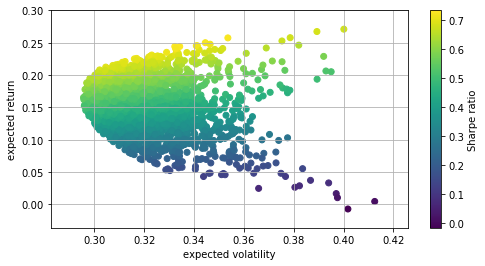

In [40]:
#2. 计算五家上市公司收益率的年化均值和方差，
rets = np.log(data / data.shift(1))#对数收益率
#使用252个交易日，从每日收益得出年化收益
print('年化均值')
print(rets.mean() * 252)
#年化方差
print('年化（协）方差')
print(rets.cov() * 252)

noa = len(symbols)
#生成随机的权重矩阵并把权重之和按比例标准化成1
weights = np.random.random(noa)
weights /= np.sum(weights)

prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

#进行蒙特卡洛模拟
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [41]:
#3. 采用投资组合理论，构建夏普指数最优的投资组合
import scipy.optimize as sco
def min_func_variance(weights):
    return statistics(weights)[1] ** 2
def min_func_sharpe(weights):
    return -statistics(weights)[2]
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])


#采用投资组合理论，构建夏普指数最优的投资组合
#1.先进行最小化投资组合波动率
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
noa * [1. / noa,]
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
#优化后的投资组合权重
print('波动率优化后的投资组合权重'+str(opts['x'].round(3)))
#预期收益率,预期波动率,最优夏普指数
print('预期收益率,预期波动率,最优夏普指数分别为:'+str(statistics(opts['x']).round(3)))
#2.再进行最小化投资组合方差
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
#优化后的投资组合权重
print('方差优化后的投资组合权重'+str(optv['x'].round(3)))
#预期收益率,预期波动率,最优夏普指数
print('预期收益率,预期波动率,最优夏普指数分别为:'+str(statistics(optv['x']).round(3)))

波动率优化后的投资组合权重[ 0.     0.372  0.033  0.595]
预期收益率,预期波动率,最优夏普指数分别为:[ 0.257  0.348  0.738]
方差优化后的投资组合权重[ 0.092  0.134  0.546  0.228]
预期收益率,预期波动率,最优夏普指数分别为:[ 0.164  0.295  0.556]


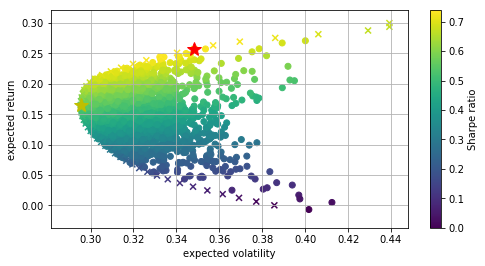

In [44]:
#4. 构建有效边界。
def min_func_port(weights):
    return statistics(weights)[1]
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
trets = np.linspace(0.0, 0.3, 50)#回报率最大值我改成了0.3
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')